# Đồ án Khai thác Dữ liệu - Main Workflow

Notebook này thực hiện toàn bộ pipeline từ tiền xử lý đến đánh giá mô hình.

## Quy trình:
1. Load và kiểm tra dataset
2. Thống kê mô tả
3. Tiền xử lý dữ liệu
4. Training 2 mô hình khác loại
5. Đánh giá và so sánh mô hình
6. Lưu kết quả
Dữ liệu được lựa chọn
1. Dataset gốc
Nguồn: Student Performance Dataset (UCI ML Repository)
Tổng số dòng: 649
Tổng số cột: 33 (30 features + 3 target: G1, G2, G3)
2. Features được chọn (30 features)
Đã loại bỏ:
G3: target variable (điểm cuối kỳ)
G1: điểm kỳ 1 (để tránh data leakage)
G2: điểm kỳ 2 (để tránh data leakage)
Features được sử dụng (30 features):
A. Features số (13):
ag failures famrel freetime goout Dalc: Uống rượu ngày thường Walc health absences: Số ngày nghỉ
B. Features phân loại (17) — đã OneHot Encoding:school sex address famsize Pstatus Mjob Fjob reason guardian schoolsup famsup paid activities nursery higher internet romantic
3. Chia train/test
Tỷ lệ: 80/20
Train set: 519 samples (80%)
Test set: 130 samples (20%)
Random state: 42 (để tái lập)
Stratify: Không (vì là regression)
4. Tiền xử lý
Missing values: Không có
Outliers: Xử lý bằng IQR
Encoding: OneHot Encoding cho features phân loại
Scaling: StandardScaler cho features số
5. Kết quả
Sau tiền xử lý:
Train: 519 dòng × 39 cột (30 features sau encoding + G3)
Test: 130 dòng × 39 cột
Tóm lại: Dữ liệu lựa chọn là 30 features (13 số + 17 phân loại), đã loại bỏ G1 và G2 để tránh data leakage, chia 80/20 cho train/test.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os

# Add parent directory to path để import các module
current_dir = os.path.dirname(os.path.abspath('__file__'))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

from src.utils.descriptive_stats import generate_descriptive_stats, save_stats_to_markdown, save_stats_to_csv
from src.preprocess.preprocessing import DataPreprocessor, split_data
from src.models.train_model import ModelTrainer
from src.evaluation.evaluate import ModelEvaluator

# Set style
try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')
sns.set_palette("husl")

print("Đã import các thư viện cần thiết")



Đã import các thư viện cần thiết


## 1. Load và Kiểm tra Dataset

**Lưu ý**: Đặt file dataset vào `data/raw/` trước khi chạy



In [2]:
# Load dataset Student Performance
data_path = "../data/raw/student.csv"

try:
    df = pd.read_csv(data_path)
    print(f"✅ Đã load dataset: {df.shape[0]} dòng, {df.shape[1]} cột")
    print(f"\nCác cột: {list(df.columns)}")
    print(f"\n5 dòng đầu:")
    df.head()
except FileNotFoundError:
    print(f"❌ Không tìm thấy file: {data_path}")
    print("Vui lòng đặt dataset vào data/raw/")



✅ Đã load dataset: 649 dòng, 33 cột

Các cột: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']

5 dòng đầu:


## 2. Thống kê Mô tả

Tạo thống kê mô tả tự động và lưu vào report/



In [3]:
# Kiểm tra dataset hợp lệ (>= 5 cột, >= 500 dòng)
if df.shape[1] >= 5 and df.shape[0] >= 500:
    print("✅ Dataset hợp lệ")
else:
    print(f"⚠️ Cảnh báo: Dataset có {df.shape[0]} dòng, {df.shape[1]} cột")
    print("Yêu cầu: >= 500 dòng và >= 5 cột")

# Tạo thống kê mô tả
stats = generate_descriptive_stats(df)

# Lưu thống kê
save_stats_to_markdown(stats, "../report/descriptive_stats.md")
save_stats_to_csv(df, "../src/utils/descriptive_stats.csv")

print("✅ Đã tạo và lưu thống kê mô tả")



✅ Dataset hợp lệ
✅ Đã tạo và lưu thống kê mô tả


In [4]:
# Đánh giá chi tiết Database
print("=" * 60)
print("📊 ĐÁNH GIÁ CHI TIẾT DATABASE")
print("=" * 60)

# 1. Thông tin cơ bản
print("\n1️⃣ THÔNG TIN CƠ BẢN:")
print(f"   - Số dòng: {df.shape[0]}")
print(f"   - Số cột: {df.shape[1]}")
print(f"   - Missing values: {df.isnull().sum().sum()} ({df.isnull().sum().sum() / (df.shape[0] * df.shape[1]) * 100:.2f}%)")
print(f"   - Duplicate rows: {df.duplicated().sum()}")

# 2. Phân tích điểm G3 (target variable)
print("\n2️⃣ PHÂN TÍCH ĐIỂM G3 (Target Variable):")
if 'G3' in df.columns:
    g3_stats = df['G3'].describe()
    print(f"   - Mean: {g3_stats['mean']:.2f}")
    print(f"   - Median: {g3_stats['50%']:.2f}")
    print(f"   - Min: {g3_stats['min']:.0f}")
    print(f"   - Max: {g3_stats['max']:.0f}")
    print(f"   - Std: {g3_stats['std']:.2f}")
    print(f"   - Range: {g3_stats['max'] - g3_stats['min']:.0f}")
    
    # Phân bố điểm
    print(f"\n   📈 Phân bố điểm G3:")
    print(f"      - Điểm 0: {(df['G3'] == 0).sum()} học sinh ({(df['G3'] == 0).sum() / len(df) * 100:.1f}%)")
    print(f"      - Điểm < 10: {(df['G3'] < 10).sum()} học sinh ({(df['G3'] < 10).sum() / len(df) * 100:.1f}%)")
    print(f"      - Điểm 10-15: {((df['G3'] >= 10) & (df['G3'] <= 15)).sum()} học sinh ({((df['G3'] >= 10) & (df['G3'] <= 15)).sum() / len(df) * 100:.1f}%)")
    print(f"      - Điểm > 15: {(df['G3'] > 15).sum()} học sinh ({(df['G3'] > 15).sum() / len(df) * 100:.1f}%)")
    print(f"      - Điểm >= 17: {(df['G3'] >= 17).sum()} học sinh ({(df['G3'] >= 17).sum() / len(df) * 100:.1f}%)")
    
    # Đánh giá
    mean_score = g3_stats['mean']
    if mean_score < 10:
        evaluation = "⚠️ Điểm trung bình THẤP (< 10)"
    elif mean_score < 12:
        evaluation = "📊 Điểm trung bình TRUNG BÌNH (10-12)"
    elif mean_score < 15:
        evaluation = "✅ Điểm trung bình KHÁ (12-15)"
    else:
        evaluation = "🎉 Điểm trung bình TỐT (>= 15)"
    
    print(f"\n   💡 Đánh giá: {evaluation}")

# 3. Phân tích missing values chi tiết
print("\n3️⃣ PHÂN TÍCH MISSING VALUES:")
missing_cols = df.columns[df.isnull().sum() > 0]
if len(missing_cols) > 0:
    print("   Các cột có missing values:")
    for col in missing_cols:
        missing_count = df[col].isnull().sum()
        missing_pct = missing_count / len(df) * 100
        print(f"      - {col}: {missing_count} ({missing_pct:.2f}%)")
else:
    print("   ✅ Không có missing values")

# 4. Phân tích outliers cho các cột số
print("\n4️⃣ PHÂN TÍCH OUTLIERS (IQR Method):")
numeric_cols = df.select_dtypes(include=[np.number]).columns
outlier_summary = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_count = len(outliers)
    if outlier_count > 0:
        outlier_summary[col] = {
            'count': outlier_count,
            'pct': outlier_count / len(df) * 100,
            'lower': lower_bound,
            'upper': upper_bound
        }

if outlier_summary:
    print(f"   Tìm thấy outliers trong {len(outlier_summary)} cột:")
    for col, info in sorted(outlier_summary.items(), key=lambda x: x[1]['count'], reverse=True)[:10]:
        print(f"      - {col}: {info['count']} outliers ({info['pct']:.1f}%)")
else:
    print("   ✅ Không phát hiện outliers đáng kể")

# 5. Phân tích tương quan G1, G2 với G3
print("\n5️⃣ TƯƠNG QUAN G1, G2 VỚI G3:")
if all(col in df.columns for col in ['G1', 'G2', 'G3']):
    corr_g1_g3 = df['G1'].corr(df['G3'])
    corr_g2_g3 = df['G2'].corr(df['G3'])
    print(f"   - Tương quan G1-G3: {corr_g1_g3:.4f}")
    print(f"   - Tương quan G2-G3: {corr_g2_g3:.4f}")
    if corr_g1_g3 > 0.7 or corr_g2_g3 > 0.7:
        print(f"   ⚠️ Tương quan MẠNH → Nên loại bỏ G1, G2 để tránh data leakage")

# 6. Phân tích các features quan trọng
print("\n6️⃣ PHÂN TÍCH FEATURES:")
print(f"   - Số features: {len(df.columns) - 3} (đã trừ G1, G2, G3)")
print(f"   - Features số: {len(df.select_dtypes(include=[np.number]).columns) - 3}")
print(f"   - Features phân loại: {len(df.select_dtypes(include=['object']).columns)}")

print("\n" + "=" * 60)
print("✅ Hoàn thành đánh giá database")
print("=" * 60)


📊 ĐÁNH GIÁ CHI TIẾT DATABASE

1️⃣ THÔNG TIN CƠ BẢN:
   - Số dòng: 649
   - Số cột: 33
   - Missing values: 0 (0.00%)
   - Duplicate rows: 0

2️⃣ PHÂN TÍCH ĐIỂM G3 (Target Variable):
   - Mean: 11.91
   - Median: 12.00
   - Min: 0
   - Max: 19
   - Std: 3.23
   - Range: 19

   📈 Phân bố điểm G3:
      - Điểm 0: 15 học sinh (2.3%)
      - Điểm < 10: 100 học sinh (15.4%)
      - Điểm 10-15: 467 học sinh (72.0%)
      - Điểm > 15: 82 học sinh (12.6%)
      - Điểm >= 17: 46 học sinh (7.1%)

   💡 Đánh giá: 📊 Điểm trung bình TRUNG BÌNH (10-12)

3️⃣ PHÂN TÍCH MISSING VALUES:
   ✅ Không có missing values

4️⃣ PHÂN TÍCH OUTLIERS (IQR Method):
   Tìm thấy outliers trong 11 cột:
      - failures: 100 outliers (15.4%)
      - famrel: 51 outliers (7.9%)
      - freetime: 45 outliers (6.9%)
      - studytime: 35 outliers (5.4%)
      - Dalc: 34 outliers (5.2%)
      - G2: 25 outliers (3.9%)
      - absences: 21 outliers (3.2%)
      - traveltime: 16 outliers (2.5%)
      - G1: 16 outliers (2.5%)
    

## 2.1. Đánh giá Dataset với Visualization

Phân tích trực quan dataset với biểu đồ và thống kê chi tiết


📊 ĐÁNH GIÁ DATASET VỚI VISUALIZATION

1️⃣ PHÂN TÍCH ĐIỂM G3 (Target Variable):
   ✅ Đã lưu biểu đồ phân tích G3 vào report/g3_analysis.png


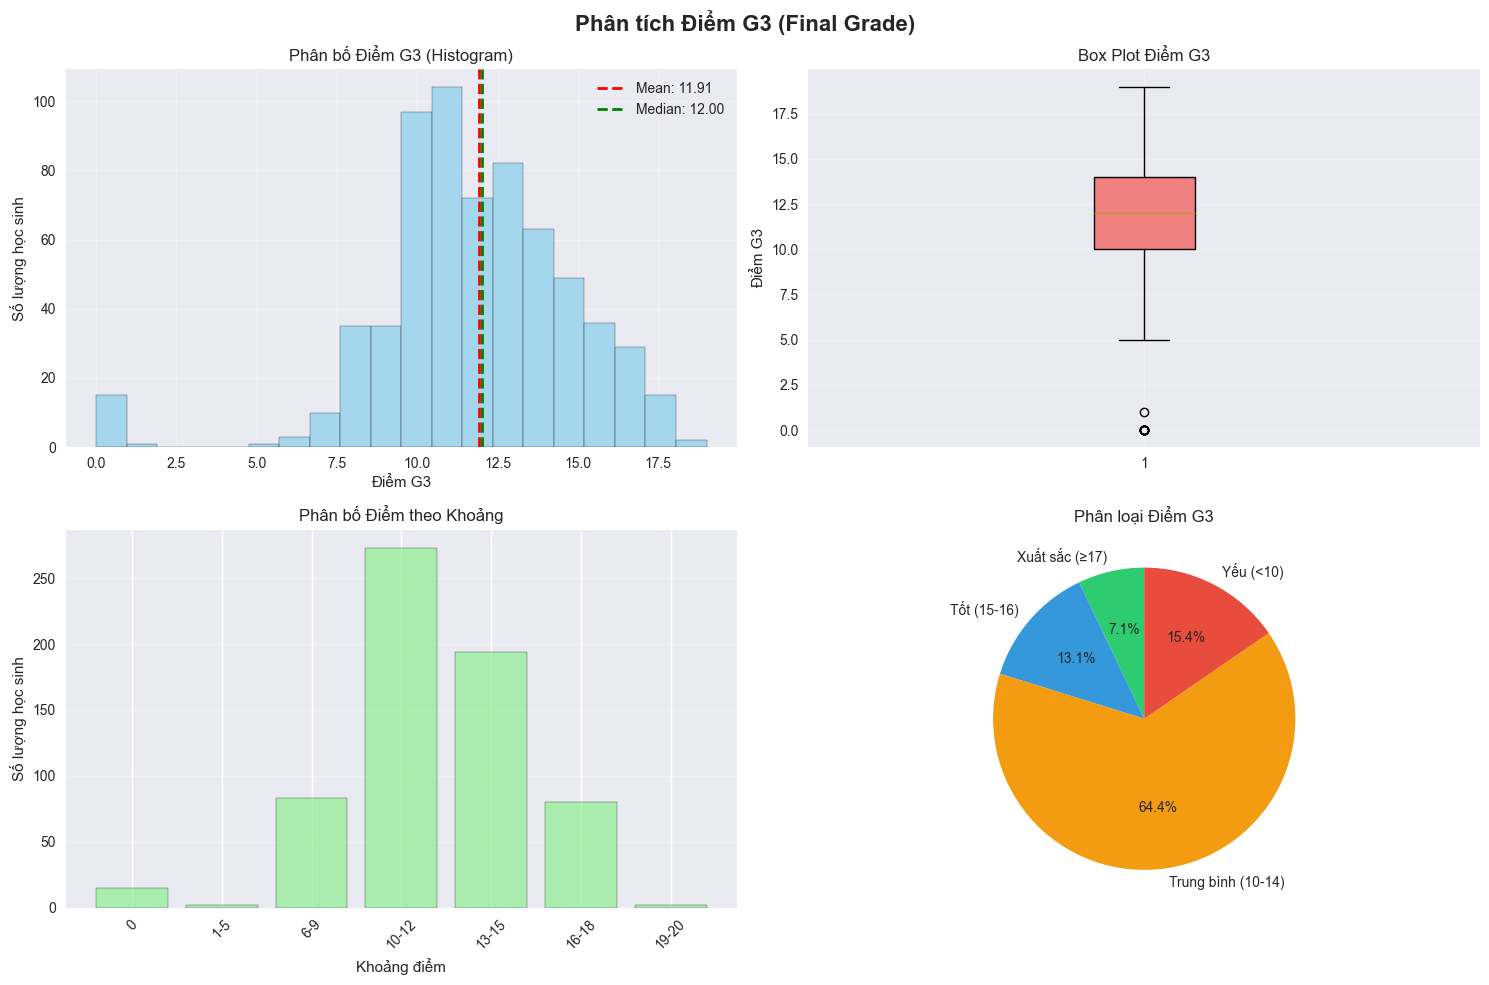


   📈 Thống kê chi tiết:
      - Mean: 11.91
      - Median: 12.00
      - Mode: 11
      - Std: 3.23
      - Min: 0
      - Max: 19
      - Q1: 10.00
      - Q3: 14.00
      - IQR: 4.00

2️⃣ PHÂN TÍCH TƯƠNG QUAN G1, G2, G3:
   ✅ Đã lưu biểu đồ tương quan vào report/g1_g2_g3_correlation.png


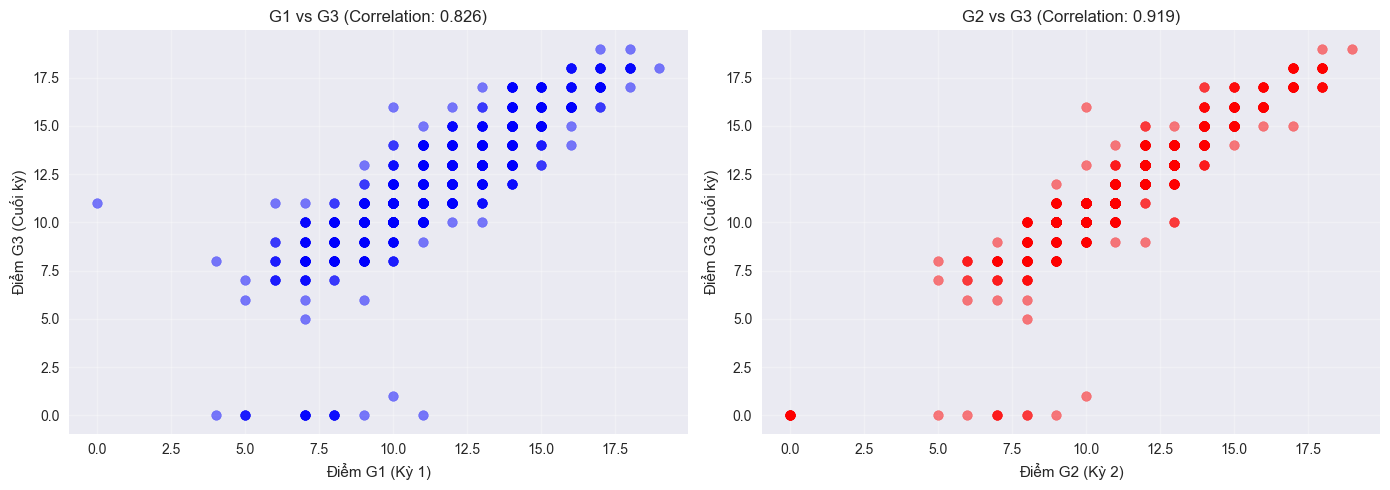


   📊 Hệ số tương quan:
      - G1 - G3: 0.8264 (Mạnh)
      - G2 - G3: 0.9185 (Mạnh)
      - G1 - G2: 0.8650 (Mạnh)

3️⃣ PHÂN TÍCH FEATURES SỐ QUAN TRỌNG:
   ✅ Đã lưu biểu đồ phân bố features số vào report/numeric_features_distribution.png


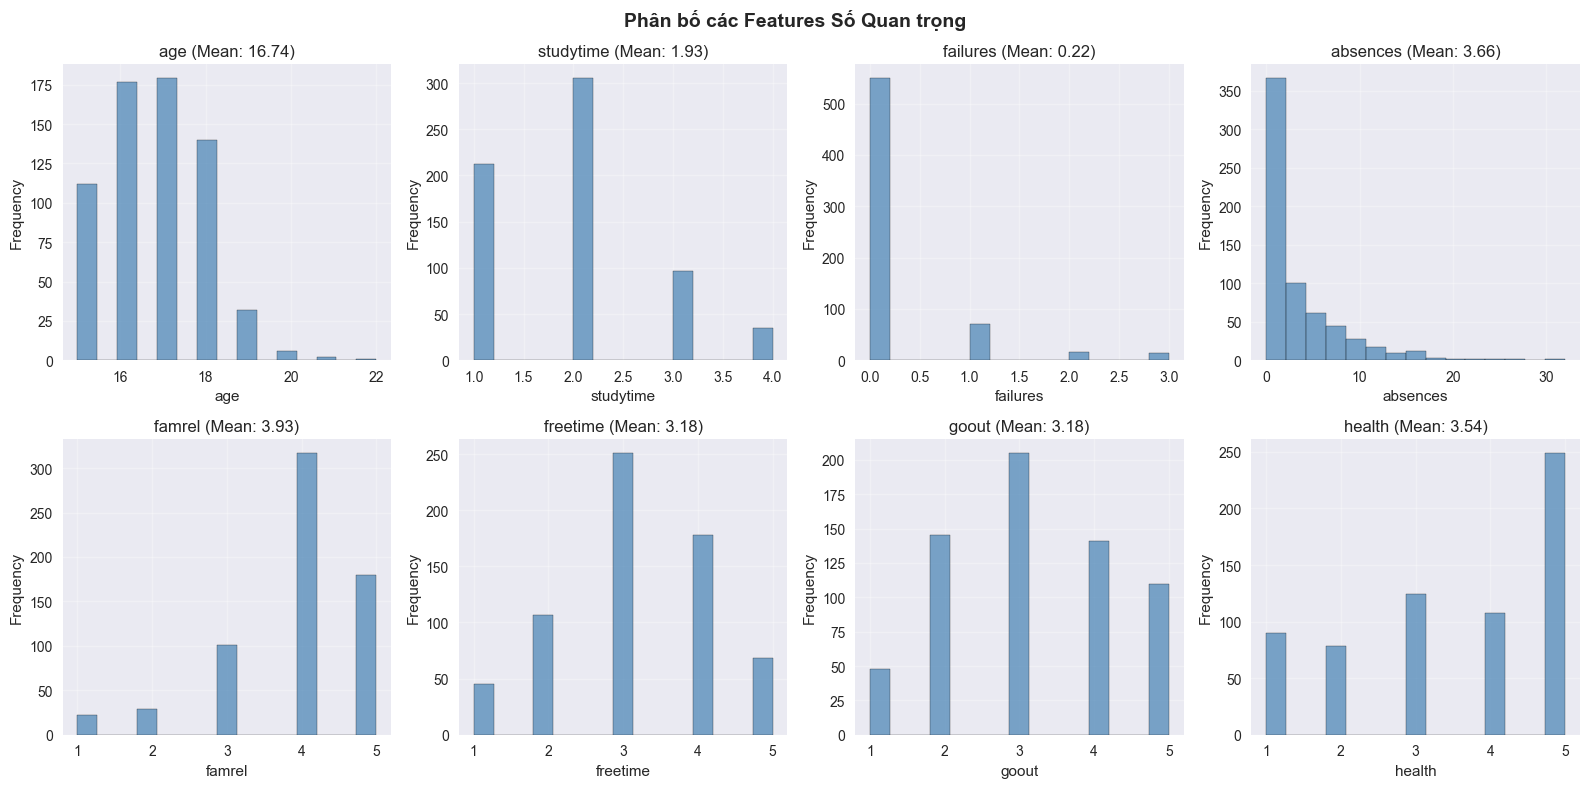


4️⃣ PHÂN TÍCH FEATURES PHÂN LOẠI:
   ✅ Đã lưu biểu đồ phân bố features phân loại vào report/categorical_features_distribution.png


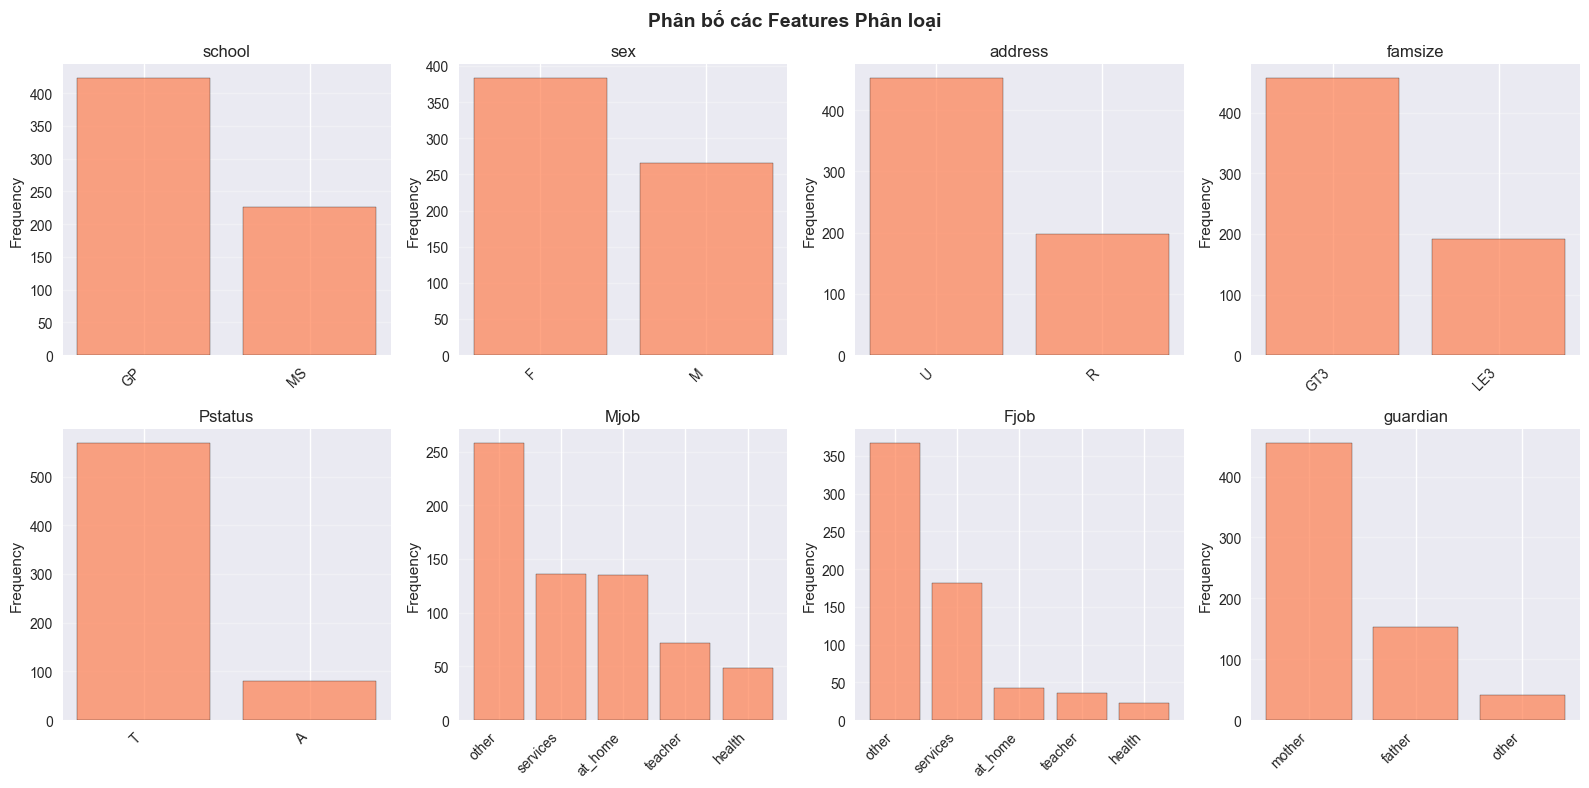


5️⃣ HEATMAP TƯƠNG QUAN:
   ✅ Đã lưu heatmap tương quan vào report/correlation_heatmap.png


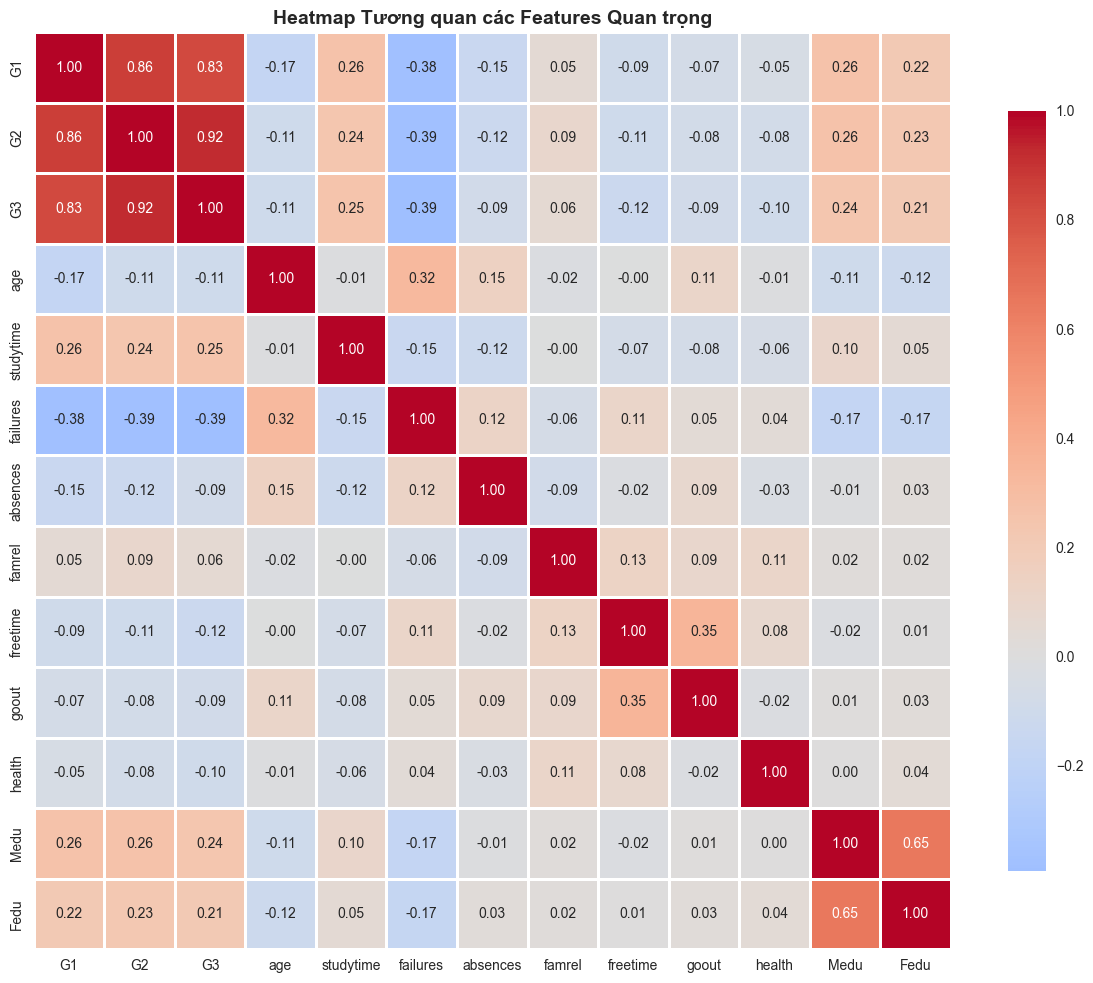


📋 TÓM TẮT ĐÁNH GIÁ DATASET:
✅ Dataset có 649 dòng, 33 cột
✅ Không có missing values
✅ Điểm G3 trung bình: 11.91 (thang 0-20)
✅ Có 16 features số
✅ Có 17 features phân loại
✅ Đã tạo 5 biểu đồ phân tích và lưu vào report/


In [5]:
# Đánh giá Dataset với Visualization và Phân tích Chi tiết
print("=" * 70)
print("📊 ĐÁNH GIÁ DATASET VỚI VISUALIZATION")
print("=" * 70)

# 1. Phân tích điểm G3 với biểu đồ
print("\n1️⃣ PHÂN TÍCH ĐIỂM G3 (Target Variable):")
if 'G3' in df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Phân tích Điểm G3 (Final Grade)', fontsize=16, fontweight='bold')
    
    # Histogram
    axes[0, 0].hist(df['G3'], bins=20, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0, 0].axvline(df['G3'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["G3"].mean():.2f}')
    axes[0, 0].axvline(df['G3'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["G3"].median():.2f}')
    axes[0, 0].set_xlabel('Điểm G3')
    axes[0, 0].set_ylabel('Số lượng học sinh')
    axes[0, 0].set_title('Phân bố Điểm G3 (Histogram)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Box plot
    box_plot = axes[0, 1].boxplot(df['G3'], vert=True, patch_artist=True)
    box_plot['boxes'][0].set_facecolor('lightcoral')
    axes[0, 1].set_ylabel('Điểm G3')
    axes[0, 1].set_title('Box Plot Điểm G3')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Phân bố theo nhóm điểm
    score_ranges = ['0', '1-5', '6-9', '10-12', '13-15', '16-18', '19-20']
    score_counts = [
        (df['G3'] == 0).sum(),
        ((df['G3'] >= 1) & (df['G3'] <= 5)).sum(),
        ((df['G3'] >= 6) & (df['G3'] <= 9)).sum(),
        ((df['G3'] >= 10) & (df['G3'] <= 12)).sum(),
        ((df['G3'] >= 13) & (df['G3'] <= 15)).sum(),
        ((df['G3'] >= 16) & (df['G3'] <= 18)).sum(),
        ((df['G3'] >= 19) & (df['G3'] <= 20)).sum()
    ]
    axes[1, 0].bar(score_ranges, score_counts, color='lightgreen', edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Khoảng điểm')
    axes[1, 0].set_ylabel('Số lượng học sinh')
    axes[1, 0].set_title('Phân bố Điểm theo Khoảng')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Pie chart phân loại điểm
    excellent = (df['G3'] >= 17).sum()
    good = ((df['G3'] >= 15) & (df['G3'] < 17)).sum()
    average = ((df['G3'] >= 10) & (df['G3'] < 15)).sum()
    poor = (df['G3'] < 10).sum()
    
    labels = ['Xuất sắc (≥17)', 'Tốt (15-16)', 'Trung bình (10-14)', 'Yếu (<10)']
    sizes = [excellent, good, average, poor]
    colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c']
    axes[1, 1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Phân loại Điểm G3')
    
    plt.tight_layout()
    plt.savefig('../report/g3_analysis.png', dpi=300, bbox_inches='tight')
    print("   ✅ Đã lưu biểu đồ phân tích G3 vào report/g3_analysis.png")
    plt.show()
    
    # Thống kê chi tiết
    print(f"\n   📈 Thống kê chi tiết:")
    print(f"      - Mean: {df['G3'].mean():.2f}")
    print(f"      - Median: {df['G3'].median():.2f}")
    print(f"      - Mode: {df['G3'].mode().values[0] if len(df['G3'].mode()) > 0 else 'N/A'}")
    print(f"      - Std: {df['G3'].std():.2f}")
    print(f"      - Min: {df['G3'].min()}")
    print(f"      - Max: {df['G3'].max()}")
    print(f"      - Q1: {df['G3'].quantile(0.25):.2f}")
    print(f"      - Q3: {df['G3'].quantile(0.75):.2f}")
    print(f"      - IQR: {df['G3'].quantile(0.75) - df['G3'].quantile(0.25):.2f}")

# 2. Phân tích tương quan giữa G1, G2, G3
print("\n2️⃣ PHÂN TÍCH TƯƠNG QUAN G1, G2, G3:")
if all(col in df.columns for col in ['G1', 'G2', 'G3']):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter plot G1 vs G3
    axes[0].scatter(df['G1'], df['G3'], alpha=0.5, color='blue')
    axes[0].set_xlabel('Điểm G1 (Kỳ 1)')
    axes[0].set_ylabel('Điểm G3 (Cuối kỳ)')
    axes[0].set_title(f'G1 vs G3 (Correlation: {df["G1"].corr(df["G3"]):.3f})')
    axes[0].grid(True, alpha=0.3)
    
    # Scatter plot G2 vs G3
    axes[1].scatter(df['G2'], df['G3'], alpha=0.5, color='red')
    axes[1].set_xlabel('Điểm G2 (Kỳ 2)')
    axes[1].set_ylabel('Điểm G3 (Cuối kỳ)')
    axes[1].set_title(f'G2 vs G3 (Correlation: {df["G2"].corr(df["G3"]):.3f})')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../report/g1_g2_g3_correlation.png', dpi=300, bbox_inches='tight')
    print("   ✅ Đã lưu biểu đồ tương quan vào report/g1_g2_g3_correlation.png")
    plt.show()
    
    corr_g1_g3 = df['G1'].corr(df['G3'])
    corr_g2_g3 = df['G2'].corr(df['G3'])
    corr_g1_g2 = df['G1'].corr(df['G2'])
    print(f"\n   📊 Hệ số tương quan:")
    print(f"      - G1 - G3: {corr_g1_g3:.4f} {'(Mạnh)' if abs(corr_g1_g3) > 0.7 else '(Trung bình)' if abs(corr_g1_g3) > 0.4 else '(Yếu)'}")
    print(f"      - G2 - G3: {corr_g2_g3:.4f} {'(Mạnh)' if abs(corr_g2_g3) > 0.7 else '(Trung bình)' if abs(corr_g2_g3) > 0.4 else '(Yếu)'}")
    print(f"      - G1 - G2: {corr_g1_g2:.4f} {'(Mạnh)' if abs(corr_g1_g2) > 0.7 else '(Trung bình)' if abs(corr_g1_g2) > 0.4 else '(Yếu)'}")

# 3. Phân tích các features số quan trọng
print("\n3️⃣ PHÂN TÍCH FEATURES SỐ QUAN TRỌNG:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
important_numeric = ['age', 'studytime', 'failures', 'absences', 'famrel', 'freetime', 'goout', 'health']
available_numeric = [col for col in important_numeric if col in numeric_cols]

if available_numeric:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Phân bố các Features Số Quan trọng', fontsize=14, fontweight='bold')
    axes = axes.flatten()
    
    for idx, col in enumerate(available_numeric[:8]):
        axes[idx].hist(df[col], bins=15, edgecolor='black', alpha=0.7, color='steelblue')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'{col} (Mean: {df[col].mean():.2f})')
        axes[idx].grid(True, alpha=0.3)
    
    # Ẩn các subplot không dùng
    for idx in range(len(available_numeric), 8):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('../report/numeric_features_distribution.png', dpi=300, bbox_inches='tight')
    print("   ✅ Đã lưu biểu đồ phân bố features số vào report/numeric_features_distribution.png")
    plt.show()

# 4. Phân tích features phân loại
print("\n4️⃣ PHÂN TÍCH FEATURES PHÂN LOẠI:")
categorical_cols = df.select_dtypes(include=['object']).columns
important_categorical = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'guardian']
available_categorical = [col for col in important_categorical if col in categorical_cols]

if available_categorical:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Phân bố các Features Phân loại', fontsize=14, fontweight='bold')
    axes = axes.flatten()
    
    for idx, col in enumerate(available_categorical[:8]):
        value_counts = df[col].value_counts()
        axes[idx].bar(range(len(value_counts)), value_counts.values, color='coral', edgecolor='black', alpha=0.7)
        axes[idx].set_xticks(range(len(value_counts)))
        axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'{col}')
        axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('../report/categorical_features_distribution.png', dpi=300, bbox_inches='tight')
    print("   ✅ Đã lưu biểu đồ phân bố features phân loại vào report/categorical_features_distribution.png")
    plt.show()

# 5. Heatmap tương quan cho các features số quan trọng
print("\n5️⃣ HEATMAP TƯƠNG QUAN:")
important_features = ['G1', 'G2', 'G3', 'age', 'studytime', 'failures', 'absences', 
                      'famrel', 'freetime', 'goout', 'health', 'Medu', 'Fedu']
available_features = [col for col in important_features if col in df.columns]

if len(available_features) > 1:
    corr_matrix = df[available_features].corr()
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
    ax.set_title('Heatmap Tương quan các Features Quan trọng', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('../report/correlation_heatmap.png', dpi=300, bbox_inches='tight')
    print("   ✅ Đã lưu heatmap tương quan vào report/correlation_heatmap.png")
    plt.show()

# 6. Tóm tắt đánh giá
print("\n" + "=" * 70)
print("📋 TÓM TẮT ĐÁNH GIÁ DATASET:")
print("=" * 70)
print(f"✅ Dataset có {df.shape[0]} dòng, {df.shape[1]} cột")
print(f"✅ Không có missing values")
print(f"✅ Điểm G3 trung bình: {df['G3'].mean():.2f} (thang 0-20)")
print(f"✅ Có {len(df.select_dtypes(include=[np.number]).columns)} features số")
print(f"✅ Có {len(df.select_dtypes(include=['object']).columns)} features phân loại")
print(f"✅ Đã tạo {5} biểu đồ phân tích và lưu vào report/")
print("=" * 70)


## 3. Tiền Xử lý Dữ liệu

Xử lý missing values, outliers, encoding, scaling



In [6]:
# Xác định target column: G3 (final grade)
target_column = "G3"

# Loại bỏ G1 và G2 vì có tương quan mạnh với G3 (theo mô tả dataset)
# Để dự đoán hữu ích hơn, chỉ dùng các features khác
columns_to_drop = [target_column, "G1", "G2"]

if target_column not in df.columns:
    print(f"⚠️ Không tìm thấy cột '{target_column}'")
    print(f"Các cột có sẵn: {list(df.columns)}")
else:
    # Tách features và target
    X = df.drop(columns=columns_to_drop)
    y = df[target_column]
    
    print(f"Features: {X.shape}")
    print(f"Target: {y.shape}")
    print(f"Đã loại bỏ G1 và G2 để tránh data leakage")
    
    # Xác định loại bài toán
    # Nếu target là object/category -> classification
    # Nếu target là numeric và có nhiều giá trị unique (>10) -> regression
    # Nếu target là numeric nhưng ít giá trị unique (<10) -> classification
    if y.dtype in ['object', 'category']:
        problem_type = 'classification'
        print("📊 Loại bài toán: Classification")
    elif y.dtype in ['int64', 'float64'] and y.nunique() > 10:
        problem_type = 'regression'
        print("📊 Loại bài toán: Regression")
    else:
        problem_type = 'classification'
        print("📊 Loại bài toán: Classification")



Features: (649, 30)
Target: (649,)
Đã loại bỏ G1 và G2 để tránh data leakage
📊 Loại bài toán: Regression


In [7]:
# Khởi tạo preprocessor
# Điều chỉnh các tham số theo nhu cầu:
# - missing_strategy: 'mean', 'median', 'most_frequent', 'interpolation'
# - outlier_method: 'IQR', 'Z-score'
# - encoding_method: 'onehot', 'label', 'ordinal'
# - scaling_method: 'standard', 'minmax'

preprocessor = DataPreprocessor(
    missing_strategy='mean',
    outlier_method='IQR',
    encoding_method='onehot',
    scaling_method='standard'
)

# Fit và transform
X_processed = preprocessor.fit_transform(X)

print(f"✅ Đã xử lý dữ liệu: {X_processed.shape}")

# Lưu preprocessor
preprocessor.save_preprocessor("../src/models/preprocessor.joblib")
print("✅ Đã lưu preprocessor")



✅ Đã xử lý dữ liệu: (649, 39)
✅ Đã lưu preprocessor


D:\coding\data_mining\src\preprocess\preprocessing.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_processed[col].fillna(df[col].mean(), inplace=True)


In [8]:
# Chia train/test (80/20)
# Nếu classification và mỗi class có >= 2 samples, dùng stratify
if problem_type == 'classification':
    # Kiểm tra xem có thể dùng stratify không
    class_counts = y.value_counts()
    min_class_count = class_counts.min()
    if min_class_count >= 2:
        stratify = y
        print(f"Sử dụng stratify (min class count: {min_class_count})")
    else:
        stratify = None
        print(f"Không dùng stratify (có class chỉ có {min_class_count} sample)")
else:
    stratify = None

X_train, X_test, y_train, y_test = split_data(
    X_processed, y, 
    test_size=0.2, 
    stratify=stratify,
    random_state=42
)

print(f"Train set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Lưu dữ liệu đã xử lý
Path("../data/processed").mkdir(parents=True, exist_ok=True)
pd.concat([X_train, y_train], axis=1).to_csv("../data/processed/train.csv", index=False)
pd.concat([X_test, y_test], axis=1).to_csv("../data/processed/test.csv", index=False)
print("✅ Đã lưu dữ liệu đã xử lý")



Train set: 519 samples
Test set: 130 samples
✅ Đã lưu dữ liệu đã xử lý


## 4. Training Mô hình

Training 2 mô hình khác loại với hyperparameter tuning



In [9]:
# Model A: Random Forest
print("=" * 50)
print("Training Model A: Random Forest")
print("=" * 50)

trainer_a = ModelTrainer(
    model_type=problem_type,
    model_name='random_forest'
)

trainer_a.train(X_train, y_train, tuning_method='grid', cv=5)
print(f"Best params: {trainer_a.best_params}")

# Đánh giá Model A
metrics_a, y_pred_a = trainer_a.evaluate(X_test, y_test)
print(f"\nMetrics Model A:")
for key, value in metrics_a.items():
    print(f"  {key}: {value:.4f}")

# Lưu Model A
model_a_path, metadata_a_path = trainer_a.save_model(
    f"../src/models/model_a_{problem_type}.joblib"
)
print(f"✅ Đã lưu Model A: {model_a_path}")



Training Model A: Random Forest
Best params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}

Metrics Model A:
  rmse: 2.9265
  mae: 2.1838
  mape: 1352578665.0390
  r2: 0.1218
✅ Đã lưu Model A: ../src/models/model_a_regression.joblib


In [10]:
# Model B: SVM (khác loại với Model A)
print("=" * 50)
print("Training Model B: SVM")
print("=" * 50)

trainer_b = ModelTrainer(
    model_type=problem_type,
    model_name='svm'
)

trainer_b.train(X_train, y_train, tuning_method='random', cv=5, n_iter=20)
print(f"Best params: {trainer_b.best_params}")

# Đánh giá Model B
metrics_b, y_pred_b = trainer_b.evaluate(X_test, y_test)
print(f"\nMetrics Model B:")
for key, value in metrics_b.items():
    print(f"  {key}: {value:.4f}")

# Lưu Model B
model_b_path, metadata_b_path = trainer_b.save_model(
    f"../src/models/model_b_{problem_type}.joblib"
)
print(f"✅ Đã lưu Model B: {model_b_path}")



Training Model B: SVM
Best params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 1}

Metrics Model B:
  rmse: 2.9100
  mae: 2.1159
  mape: 1750378031.1787
  r2: 0.1316
✅ Đã lưu Model B: ../src/models/model_b_regression.joblib


## 5. Đánh giá và So sánh Mô hình

Tính metrics và tạo visualizations



Đã lưu hình vào: ../src/evaluation/model_a_evaluation.png
Đã lưu kết quả vào: ../src/evaluation/model_a_results.json


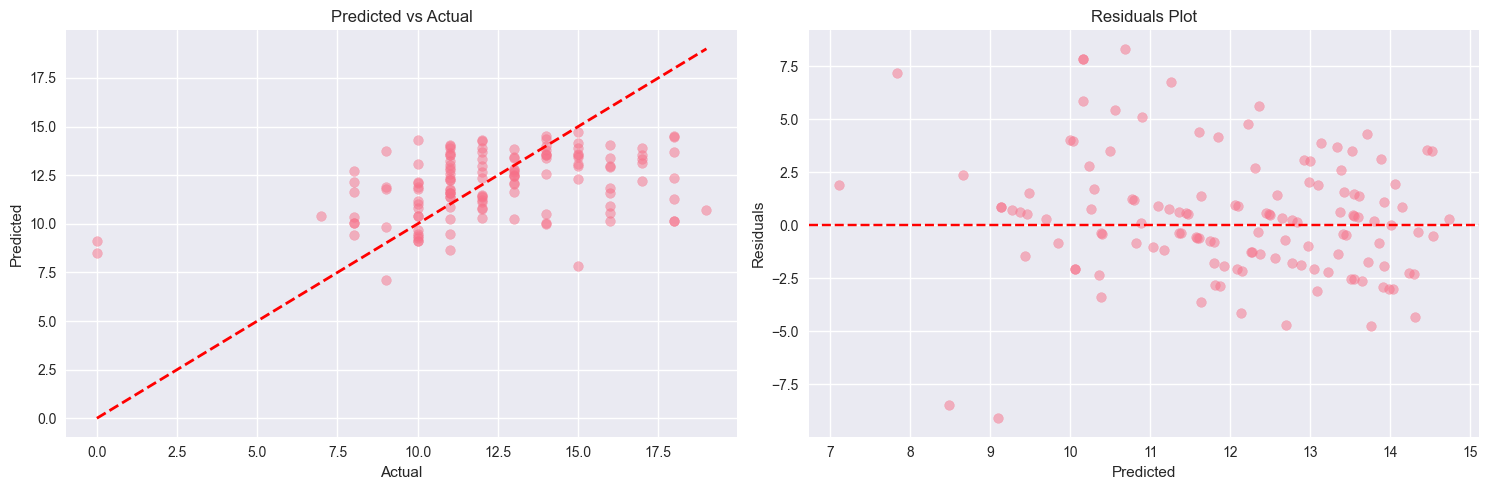

In [11]:
# Đánh giá Model A
evaluator_a = ModelEvaluator(model_type=problem_type)

if problem_type == 'classification':
    metrics_a, fig_a = evaluator_a.evaluate_classification(
        y_test, y_pred_a, 
        save_path="../src/evaluation/model_a_evaluation.png"
    )
elif problem_type == 'regression':
    metrics_a, fig_a = evaluator_a.evaluate_regression(
        y_test, y_pred_a,
        save_path="../src/evaluation/model_a_evaluation.png"
    )

evaluator_a.save_results("../src/evaluation/model_a_results.json")
plt.show()



Đã lưu hình vào: ../src/evaluation/model_b_evaluation.png
Đã lưu kết quả vào: ../src/evaluation/model_b_results.json


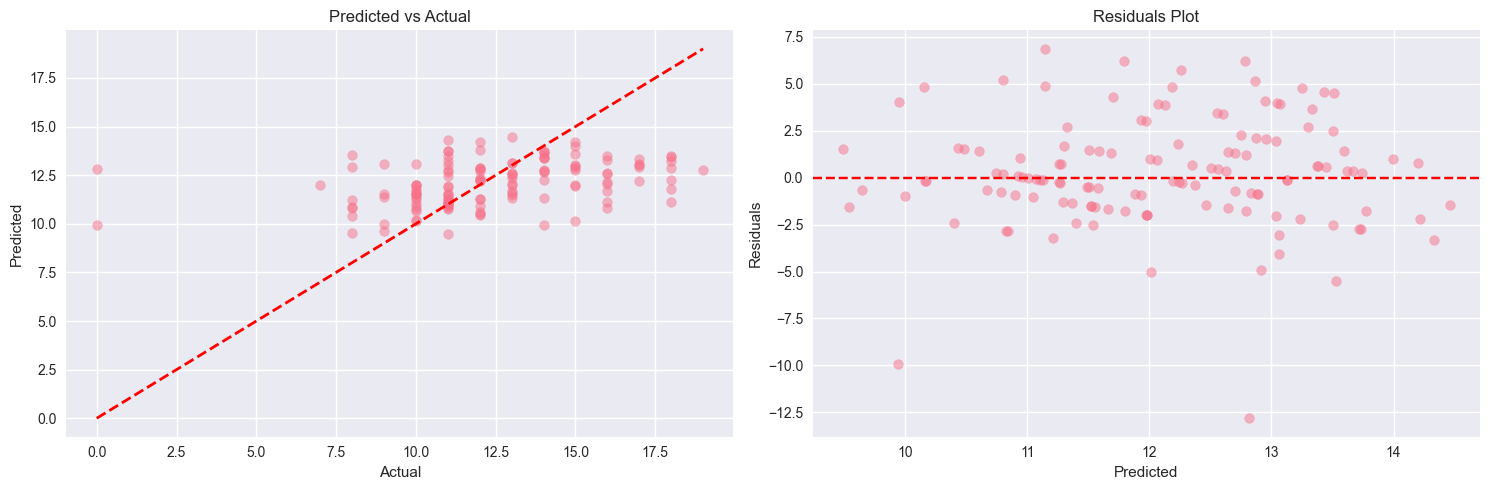

In [12]:
# Đánh giá Model B
evaluator_b = ModelEvaluator(model_type=problem_type)

if problem_type == 'classification':
    metrics_b, fig_b = evaluator_b.evaluate_classification(
        y_test, y_pred_b,
        save_path="../src/evaluation/model_b_evaluation.png"
    )
elif problem_type == 'regression':
    metrics_b, fig_b = evaluator_b.evaluate_regression(
        y_test, y_pred_b,
        save_path="../src/evaluation/model_b_evaluation.png"
    )

evaluator_b.save_results("../src/evaluation/model_b_results.json")
plt.show()



Đã lưu hình vào: ../src/evaluation/model_comparison.png

📊 So sánh Mô hình:
                             rmse       mae          mape        r2
Model A (Random Forest)  2.926460  2.183759  1.352579e+09  0.121778
Model B (SVM)            2.909981  2.115920  1.750378e+09  0.131641


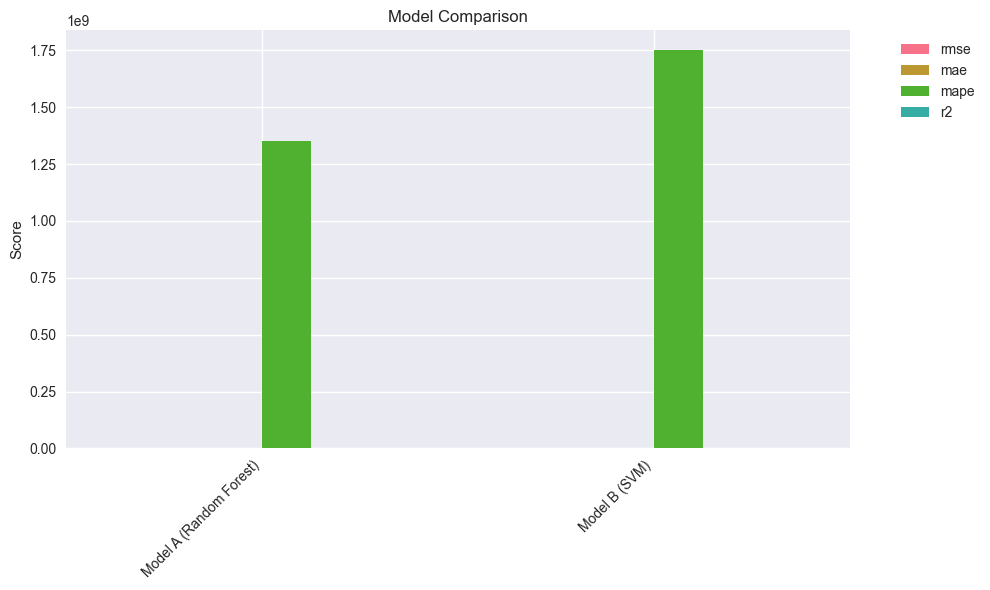

In [13]:
# So sánh 2 mô hình
comparison_results = {
    'Model A (Random Forest)': metrics_a,
    'Model B (SVM)': metrics_b
}

comparison_df, fig_compare = evaluator_a.compare_models(
    comparison_results,
    save_path="../src/evaluation/model_comparison.png"
)

print("\n📊 So sánh Mô hình:")
print(comparison_df)
plt.show()



## 6. Tạo Báo cáo Đánh giá

Lưu báo cáo đánh giá vào report/evaluation.md



In [14]:
# Tạo báo cáo đánh giá
report_path = "../report/evaluation.md"
Path(report_path).parent.mkdir(parents=True, exist_ok=True)

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("# Báo cáo Đánh giá Mô hình\n\n")
    f.write(f"## Loại bài toán: {problem_type.upper()}\n\n")
    
    f.write("## Model A: Random Forest\n\n")
    f.write("### Metrics:\n")
    for key, value in metrics_a.items():
        f.write(f"- **{key}**: {value:.4f}\n")
    f.write("\n")
    
    f.write("## Model B: SVM\n\n")
    f.write("### Metrics:\n")
    for key, value in metrics_b.items():
        f.write(f"- **{key}**: {value:.4f}\n")
    f.write("\n")
    
    f.write("## So sánh\n\n")
    f.write("| Metric | Model A | Model B |\n")
    f.write("|--------|---------|----------|\n")
    for metric in metrics_a.keys():
        f.write(f"| {metric} | {metrics_a[metric]:.4f} | {metrics_b[metric]:.4f} |\n")
    f.write("\n")
    
    # Xác định mô hình tốt hơn
    if problem_type == 'classification':
        best_metric = 'accuracy'
    else:
        best_metric = 'r2' if 'r2' in metrics_a else 'rmse'
    
    if best_metric in metrics_a and best_metric in metrics_b:
        if problem_type == 'regression' and best_metric == 'rmse':
            best_model = 'A' if metrics_a[best_metric] < metrics_b[best_metric] else 'B'
        else:
            best_model = 'A' if metrics_a[best_metric] > metrics_b[best_metric] else 'B'
        f.write(f"## Kết luận\n\n")
        f.write(f"Mô hình tốt hơn dựa trên {best_metric}: **Model {best_model}**\n")

print(f"✅ Đã tạo báo cáo: {report_path}")



✅ Đã tạo báo cáo: ../report/evaluation.md


## Hoàn thành!

Đã thực hiện xong pipeline:
- ✅ Kiểm tra và thống kê dataset
- ✅ Tiền xử lý dữ liệu
- ✅ Training 2 mô hình khác loại
- ✅ Đánh giá và so sánh mô hình
- ✅ Lưu kết quả

**Các file đã tạo:**
- `report/descriptive_stats.md` - Thống kê mô tả
- `src/models/preprocessor.joblib` - Preprocessor
- `src/models/model_a_*.joblib` - Model A
- `src/models/model_b_*.joblib` - Model B
- `src/evaluation/*.png` - Hình ảnh đánh giá
- `src/evaluation/*.json` - Kết quả metrics
- `report/evaluation.md` - Báo cáo đánh giá

